# Imports

In [16]:
import os
import shutil
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from src.helperFunctions import createDir

# Data

This [dataset](https://zenodo.org/record/4002935#.Yy3e-KTML30) contains 64,947 landmark images that were detected and extracted from the [High Resolution Imaging Science Experiment](https://www.uahirise.org/) (HiRISE) browse images, spanning 232 different source images.

This set was built from 10,815 landmarks. Each landmark was cropped to square bounding box that included the full extent of the landmark and a 30-pixel margin to the top, bottom, left, and right. Each landmark was then resized to 227 x 227 pixels. 9,022 of these images were then augmented to generate 6 additional landmarks using the following methods:

1. 90 degrees clockwise rotation
2. 180 degrees clockwise rotation
3. 270 degrees clockwise rotation
4. Horizontal flip
5. Vertical flip
6. Random brightness adjustment

The remaining 1,793 images weren't augmented. Combining these with the (7 * 9,022) 63,154 images,  gives us 64,947 separate images.

In [34]:
# Specify the path to the 'data' folder
# We will place unzipped files here
data = 'data'

In [3]:
# We extract the zipped files and place them in the data folder 
# This cell may take 2-4 mins to run 

with zipfile.ZipFile('./data/hirise-map-proj-v3_2.zip', 'r') as zippedData:
    zippedData.extractall(path=data)

In [35]:
# Set path to 'data/hirise-map-proj-v3_2' by joining them with a '/'
path = '/'.join([data, 
                 'hirise-map-proj-v3_2'])

# Specify the path to the images folder
# We will place images here
images = 'images'

print(path)
print(images)

data/hirise-map-proj-v3_2
images


In [36]:
# Read the 'labels-map-proj_v3_2_train_val_test' txt file 
# by joining it to the end of path with a '/' 
image_map = pd.read_csv(
    '/'.join([path, 
              'labels-map-proj_v3_2_train_val_test.txt']), 
    header=None,
    
    # Label the columns in the txt file
    names=['image_name', 
           'class', 
           'image_set'],
    
    # Set delimiter to a space
    delimiter=' ')

# Display image_map
image_map

,image_name,class,image_set
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
2,ESP_013049_0950_RED-0067-brt.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train
...,...,...,...
67805,ESP_018707_2205_RED-0041.jpg,0,test
67806,ESP_018707_2205_RED-0062.jpg,0,test
67807,ESP_018707_2205_RED-0105.jpg,0,test
67808,ESP_018707_2205_RED-0058.jpg,0,test


In [37]:
# Read the 'landmarks_map-proj-v3_2_classmap' csv file 
# by joining it to the end of path with a '/' 
class_decoder = pd.read_csv(
    '/'.join([path, 
              'landmarks_map-proj-v3_2_classmap.csv']),
    header=None,
    
    # Label the columns in the csv file
    names=['class', 
           'class_type'])

# Display class_decoder
class_decoder

,class,class_type
0,0,other
1,1,crater
2,2,dark dune
3,3,slope streak
4,4,bright dune
5,5,impact ejecta
6,6,swiss cheese
7,7,spider


We are going to <b>merge image_map</b> and <b>class_decoder</b> on *'class'* because we want to add a the *'class_type'* column to image_map. Not only will we have the *'class'* number for each image, we'll also have the name of the type of landmark in the image.

In [38]:
# Merge image_map and class_decoder on 'class' and drop duplicates
image_map = image_map.merge(class_decoder, 
                            on='class').drop_duplicates()

# Display image_map
image_map

,image_name,class,image_set,class_type
0,ESP_013049_0950_RED-0067.jpg,7,train,spider
1,ESP_013049_0950_RED-0067-fv.jpg,7,train,spider
2,ESP_013049_0950_RED-0067-brt.jpg,7,train,spider
3,ESP_013049_0950_RED-0067-r90.jpg,7,train,spider
4,ESP_013049_0950_RED-0067-r180.jpg,7,train,spider
...,...,...,...,...
67805,ESP_016613_2570_RED-0038.jpg,4,test,bright dune
67806,ESP_016613_2570_RED-0006.jpg,4,test,bright dune
67807,ESP_016613_2570_RED-0043.jpg,4,test,bright dune
67808,ESP_016613_2570_RED-0044.jpg,4,test,bright dune


We can see the data is <b>split</b> into <b>train, test,</b> and <b>validation</b>. We'll create <b>3</b> folders and inside them we'll place <b>8</b> folders labeled with the *'class_type'*. This will be the projects folder system. Now, our neural networks can access the images for modeling using `tensorflow`'s `flow_from_directory`.

In [8]:
# We are constructing the folder system for the images and data
# Create images folder
createDir(images)

# Loops through 'image_set' to get use it's unique values (train, test, val)
# as the names of folders we will place images in 
for image_folder in set(image_map['image_set']):
    
    # Create folders train, test, and val 
    # and place them inside the images folder
    createDir('/'.join([images,
                        image_folder]))
    
    # Loops through 'class_type' to get use it's unique values 
    # (other, impact ejecta, spider, swiss cheese, slope, crater, dark dune, bright dune)
    # as the names of folders we will place images in 
    for class_folder in set(image_map['class_type']):       
        for class_folder in set(class_decoder['class_type']):       
            
            # Create folders with unique names listed above and place them
            # in test, train or val folders
            createDir('/'.join([images, 
                                image_folder, 
                                class_folder]))

images directory already exists
images/test directory already exists
images/test/spider directory already exists
images/test/other directory already exists
images/test/slope streak directory already exists
images/test/crater directory already exists
images/test/dark dune directory already exists
images/test/impact ejecta directory already exists
images/test/bright dune directory already exists
images/test/swiss cheese directory already exists
images/test/spider directory already exists
images/test/other directory already exists
images/test/slope streak directory already exists
images/test/crater directory already exists
images/test/dark dune directory already exists
images/test/impact ejecta directory already exists
images/test/bright dune directory already exists
images/test/swiss cheese directory already exists
images/test/spider directory already exists
images/test/other directory already exists
images/test/slope streak directory already exists
images/test/crater directory already e

In [9]:
# This cell may take 15-20 mins to run
# Loops through every 'file' in the folder 
# 'data/hirise-map-proj-v3_2/map-proj-v3_2'
for file in os.listdir('/'.join([path, 
                                 'map-proj-v3_2'])):
    
    # Access the 'image_set' of each file
    set_folder = image_map[image_map['image_name'] == file].iloc[0]['image_set']
    
    # Access the 'class_type' of each file
    class_folder = image_map[image_map['image_name'] == file].iloc[0]['class_type'] 
    
    # Set src_path to "data/hirise-map-proj-v3_2/map-proj-v3_2/'file'"
    src_path  = '/'.join([path, 
                          'map-proj-v3_2', 
                          file])
    
    # Set dest_path to "images/'image_set'/'class_type'/'file'"
    dest_path = str('images/' + set_folder + "/" + class_folder + "/" + file)
    
    # Next we place the images into their corresponding folders
    shutil.move(src_path,
                dest_path)

## Classes
The various landmarks that make up our 8 classes: 

1.  <b>Dark dune</b> and bright dune are 2 sand dune classes on Mars. Dark dunes are completely defrosted, and bright dunes are not.
<img src="images/notebook/dark_dune.jpg" width="500" height="500">


2. <b>Bright dunes</b> are typically bright due to overlying frost. Black spots can be seen where parts of the dune are defrosting.
<img src="images/notebook/bright_dune.jpg" width="500" height="500">

3. <b>Crater</b> class consists of images in which the diameter of the crater is equal to or greater than 1/5 the width of the image plus the circular rim is visible for at least half of the crater's circumference.
<img src="images/notebook/crater.jpg" width="500" height="500">

4. <b>Slope streak</b> class consists of images of dark flow-like features on slopes. Scientists believe these features were formed by a dry process in which overlying (bright) dust tumbles down a slope and expose a darker sub-surface.
<img src="images/notebook/slope_streak.jpg" width="500" height="500">

5. <b>Impact ejecta</b> is material that's blasted out from a volcano eruption or meteorite impact. They also include cases in which the impact cleared away overlying dust, revealing the underlying surface. In some cases, the crater isn't be visible because it's too small to see. Impact ejecta may also include lava that poured out from the impact (blobby ("lobate") rather than blast-like), more like an eruption (triggered by the impact). Impact ejecta can be isolated, or they can form in batches when the impactor breaks up into numerous pieces.
<img src="images/notebook/impact_ejecta.jpg" width="500" height="500">

6. <b>Spiders</b> and Swiss cheese are phenomena that occur in the south polar region of Mars. Spiders have a central pit with radial troughs, and could be formed due to sublimation of carbon dioxide ice. This process can create mineral deposits on top, which resemble light or dark dust that highlights cracks in the CO2 ice. Spiders can resemble impact ejecta due to their radial troughs, but impact ejecta typically have straight radial jets that get dimmer as they get farther from the center. The spider class also includes fan-like features that form when a geyser erupts through the CO2 layer and the material is blown away from the cracks by the wind. Fans are generally unidirectional (following the wind direction), whereas impact ejecta can fanout in multiple directions.
<img src="images/notebook/spider.jpg" width="500" height="500">

7. <b>Swiss cheese</b> is a landmark type that includes pits that are formed when the sun heats the ice causing sublimation (change from solid to gas).
<img src="images/notebook/swiss_cheese.jpg" width="500" height="500">

8. <b>Other</b> is a catch-all class that contains images that don't fit into any of the classes above. This class comprises the majority of this data.
<img src="images/notebook/other.jpg" width="500" height="500">

In [10]:
# Check out breakdown of 'class_type' by percentage
image_map['class_type'].value_counts(normalize=True)

other            0.811770
crater           0.077355
swiss cheese     0.028238
bright dune      0.025467
slope streak     0.024251
spider           0.013796
dark dune        0.011794
impact ejecta    0.007329
Name: class_type, dtype: float64

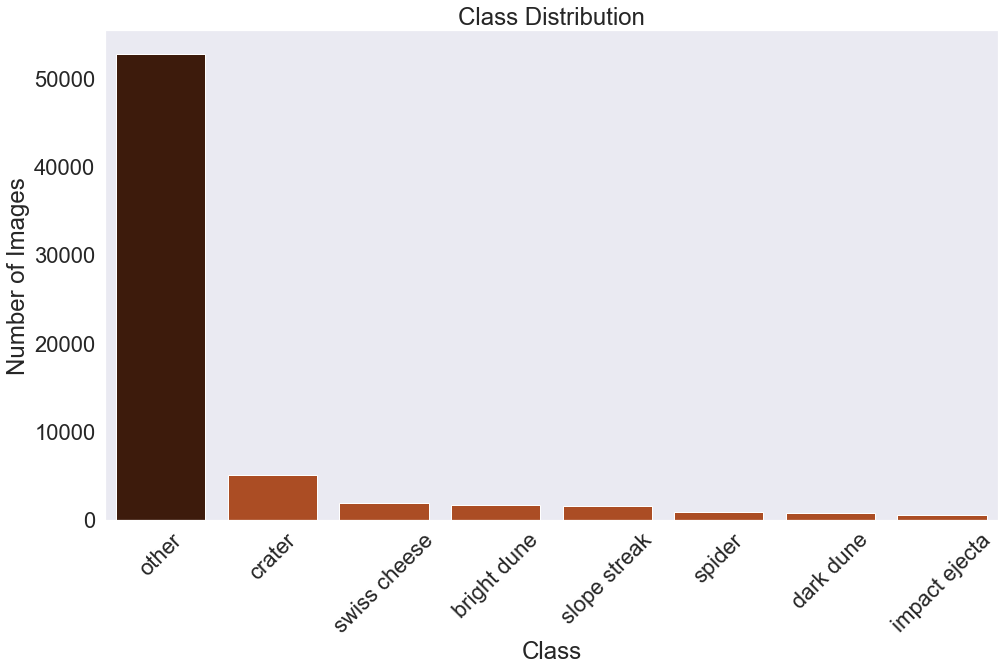

In [60]:
# Set colors based on googled Mars color codes
dark_mars = '#451804'
red_mars = '#c1440e'

# Set figure size
sns.set(rc={'figure.figsize':(16, 9)})

# Set font size
sns.set(font_scale=2)

# Set backgroung style to 'dark'
sns.set_style('dark')

# Bar plot 'class_type'] value_counts
sns.barplot(x=image_map['class_type'].value_counts().index,
            y=image_map['class_type'].value_counts().values,
            palette=[dark_mars, red_mars, red_mars, red_mars, red_mars, red_mars, red_mars, red_mars])

# Label the barplot, x-axis, and y-axis
plt.title('Class Distribution') 
plt.ylabel('Number of Images') 
plt.xlabel('Class')
plt.xticks(rotation=45)

# Save figure in figures folder
plt.savefig('./figures/image_dist.jpg', 
            dpi='figure',
            bbox_inches='tight',
            pad_inches=0.1,
            facecolor='auto',
            edgecolor='auto');

Our data is very <b>imbalanced</b>. Over <b>81%</b> belongs to *'class_type'*  <b>other</b> and <b>7%</b> belongs to <b>crater</b>.

In [58]:
# View the train, test, and validation split by checking the normalized value_counts of 'image_set'
image_map['image_set'].value_counts(normalize=True)

train    0.754138
val      0.218255
test     0.027607
Name: image_set, dtype: float64

In [12]:
# View the 'class_type' breakdown of the train dataset
image_map[image_map['image_set'] == 'train']['class_type'].value_counts(normalize=True)

other            0.817064
crater           0.073460
bright dune      0.031871
swiss cheese     0.026154
slope streak     0.018865
spider           0.013006
dark dune        0.012577
impact ejecta    0.007003
Name: class_type, dtype: float64

In [13]:
# View the 'class_type' breakdown of the validation dataset
image_map[image_map['image_set'] == 'val']['class_type'].value_counts(normalize=True)

other            0.791605
crater           0.094321
slope streak     0.042469
swiss cheese     0.036049
spider           0.015309
impact ejecta    0.008889
dark dune        0.005926
bright dune      0.005432
Name: class_type, dtype: float64

In [14]:
# View the 'class_type' breakdown of the test dataset
image_map[image_map['image_set'] == 'test']['class_type'].value_counts(normalize=True)

other            0.826548
crater           0.049637
dark dune        0.036810
slope streak     0.027328
spider           0.023424
swiss cheese     0.023424
bright dune      0.008924
impact ejecta    0.003904
Name: class_type, dtype: float64

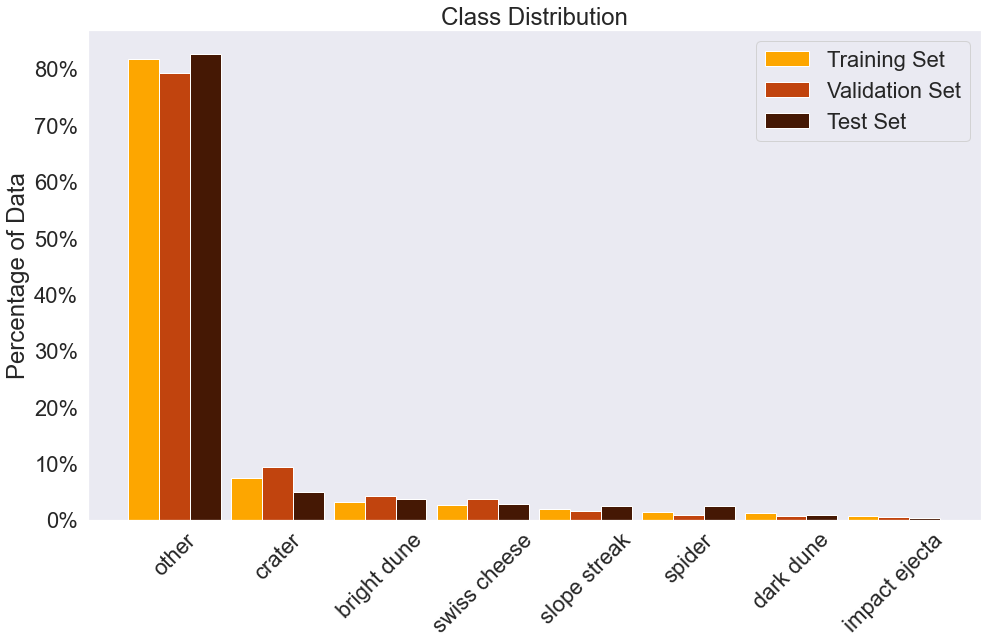

In [64]:
# Set colors based on googled Mars color codes
dark_mars = '#451804'
red_mars = '#c1440e'
dune_mars = '#fda600'

# Set the xlabels to the train 'class_type' index
xlabels= image_map[image_map['image_set'] == 'train']['class_type'].value_counts(normalize=True).index

# Filter out the data with 'image_set' train and access 'class_type' normalized value_counts of 'class_type'
train = image_map[image_map['image_set'] == 'train']['class_type'].value_counts(normalize=True).values

# Filter out the data with 'image_set' validation and access 'class_type' normalized value_counts of 'class_type'
val = image_map[image_map['image_set'] == 'val']['class_type'].value_counts(normalize=True).values

# Filter out the data with 'image_set' test and access 'class_type' normalized value_counts of 'class_type'
test = image_map[image_map['image_set'] == 'test']['class_type'].value_counts(normalize=True).values

# Create plot and set figure size
fig, ax = plt.subplots(figsize = (16, 9))

# Set xticks
xticks=np.arange(len(xlabels))

# Set width 
width=0.3

# Bar plot xticks subtract width to create 1st bar for train
ax.bar(x=xticks-width, 
       height=train, 
       width=width, 
       color=dune_mars)

# Bar plot xticks to create 2nd bar for val
ax.bar(x=xticks, 
       height=val, 
       width=width, 
       color=red_mars)

# Bar plot xticks plus width to create 3rd bar for test
ax.bar(x=xticks+width, 
       height=test,
       width=width,
       color=dark_mars)

# Set backgroung style to 'dark'
sns.set_style('dark')

# Label the barplot, y-axis, and xticks
ax.set_ylabel('Percentage of Data')
ax.set_title('Class Distribution')
ax.set_xticks(np.arange(len(xlabels)))
ax.set_xticklabels(xlabels)
plt.xticks(rotation=45)

# Label the legend
ax.legend(('Training Set', 
           'Validation Set', 
           'Test Set'))

# Set yticks to percentages
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(f'{round(x*100)}%')))

# Save figure in figures folder
plt.savefig('./figures/image_dist_set.jpg', 
            dpi='figure', 
            bbox_inches='tight', 
            pad_inches=0.1,
            facecolor='auto',
            edgecolor='auto');

Our <b>test</b> and <b>validation</b> splits are also very <b>imbalanced</b>. Over <b>82%</b> and <b>79%</b> belong to *'class_type'*  <b>other</b>. A dummy model would perform just as well. Our models must perform better than this. We can address the imbalance by using <b>validation loss</b> plus <b>validation accuracy</b> metrics to keep track of our model performance. 

# Modeling Methodology

We can now start the modeling process. I attempted a 3 pronged approach to modeling:
- Training models from scratch trying a variety of different architectures.
> [01_TensorflowModeling_CNN](./01_TensorflowModeling_CNN.ipynb) details the variety of different of models with increasing and decreasing complexity/regularization. 
>[02_TensorflowModeling_FinalModels](./02_TensorflowModeling_FinalModels.ipynb) takes a subset of promising models from above and further refines them to get the most out of them
- Training models on pre-established Convolutional Neural Net model architectures with a random weight initialization., namely:
 - AlexNet
 >[03_TensorflowModeling_AlexNet](./03_TensorflowModeling_AlexNet.ipynb) details the AlexNet training
 - LeNet-5
 >[04_TensorflowModeling_LeNet](./04_TensorflowModeling_LeNet.ipynb) details the LeNet-5 training
- Training on pre-trained models using transfer learning. The model of choice is VGG-16.
>[05_TensorflowModeling_VGG16_TransferLearning](./05_TensorflowModeling_VGG16_TransferLearning.ipynb) details transfer learning on the VGG16 architecture

Finally, in [06_AnomalyDetection](./06_AnomalyDetection.ipynb), the best performing model is loaded and used to predict features on satellite images of Martian topography.